# Assignment 3

## Filepaths & Variable Declarations

In [1]:
GPA_GRE_FILE = './data/gpa-gre.csv'
DWELL_TIMES_FILE = './data/multiple-sites.tsv'

## Imports

In [2]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Function declarations and setup

In [3]:
sns.set()
DPI = 200

def plot_large():
    plt.figure(figsize=(8,5), dpi=DPI)

## Problem 1: GPA-GRE Regression with SciKit

In [4]:
df = pd.read_csv(GPA_GRE_FILE)
df['Combined'] = df['Verbal'] + df['Quant']
df = df.dropna(subset=['Combined'])
df.head()

,Year,GPA,Verbal,Quant,Combined
0,1,4.00,420.0,800.0,1220.0
1,1,3.88,480.0,770.0,1250.0
2,1,3.88,480.0,780.0,1260.0
3,1,3.87,440.0,690.0,1130.0
4,1,3.85,320.0,800.0,1120.0


In [5]:
X = df['Combined'].values.reshape(-1, 1)
y = df['GPA']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

### a) Linear Regression Model

In [6]:
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X_train, y_train);

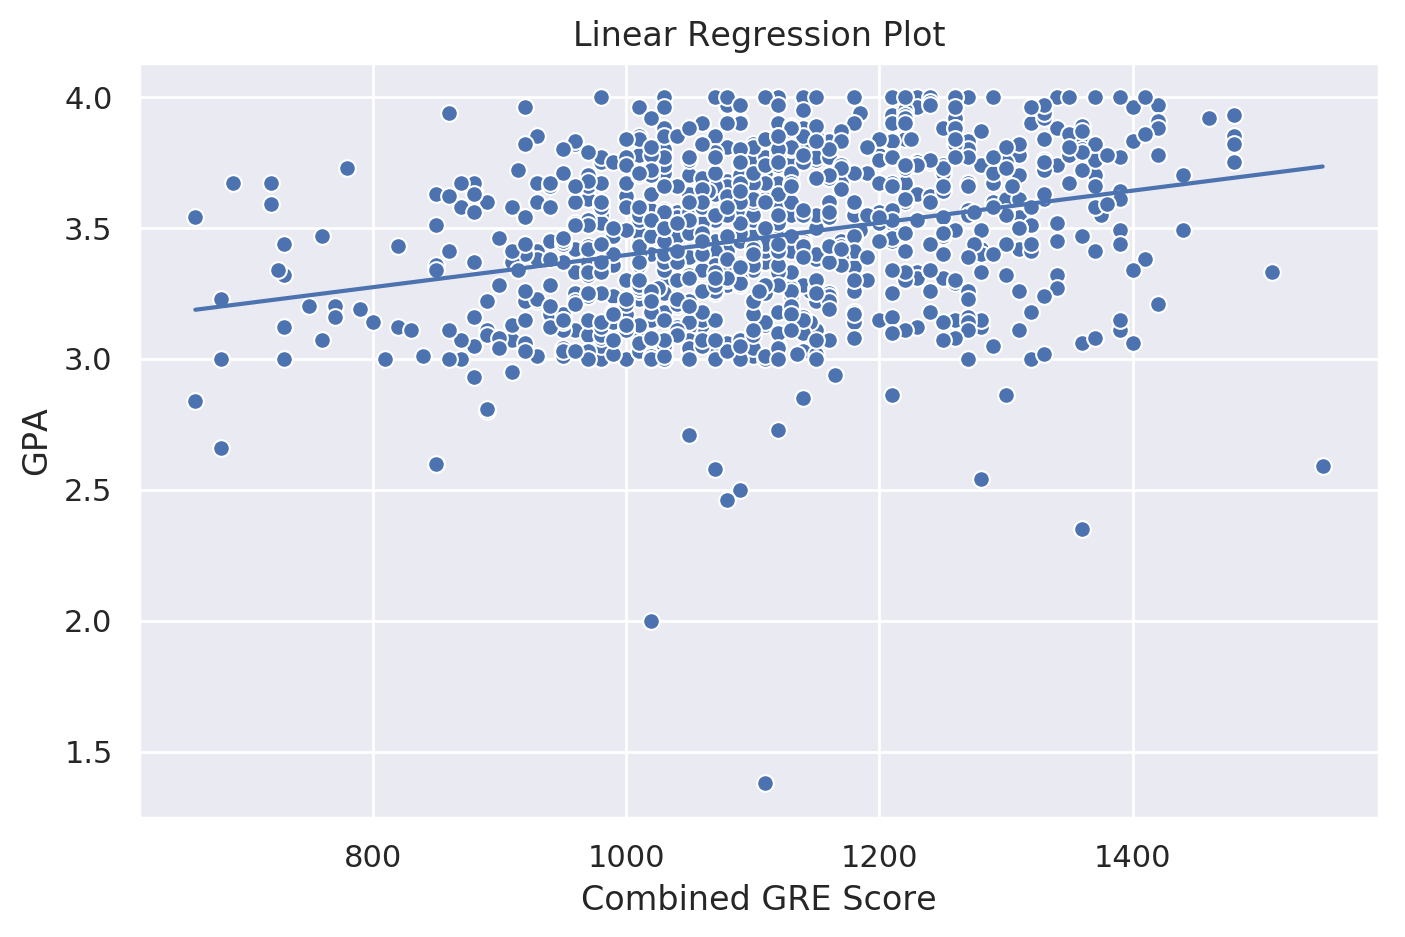

In [14]:
plot_large()
sns.scatterplot(x=np.hstack(X_train), y=y_train)
sns.lineplot(x=np.hstack(X_train), y=linear_model.predict(X_train))
plt.xlabel('Combined GRE Score')
plt.ylabel('GPA')
plt.title('Linear Regression Plot');

### b) R2 Score

In [8]:
y_pred = linear_model.predict(X_test)
sklearn.metrics.r2_score(y_test, y_pred)

0.10000571865934571

### c) Residuals Plot

In [9]:
residuals = y_test - y_pred
print("Sum of residuals: {}".format(residuals.sum()))
print("Mean of residuals: {}".format(residuals.mean()))

Sum of residuals: -5.745035276462996
Mean of residuals: -0.03546318071890738


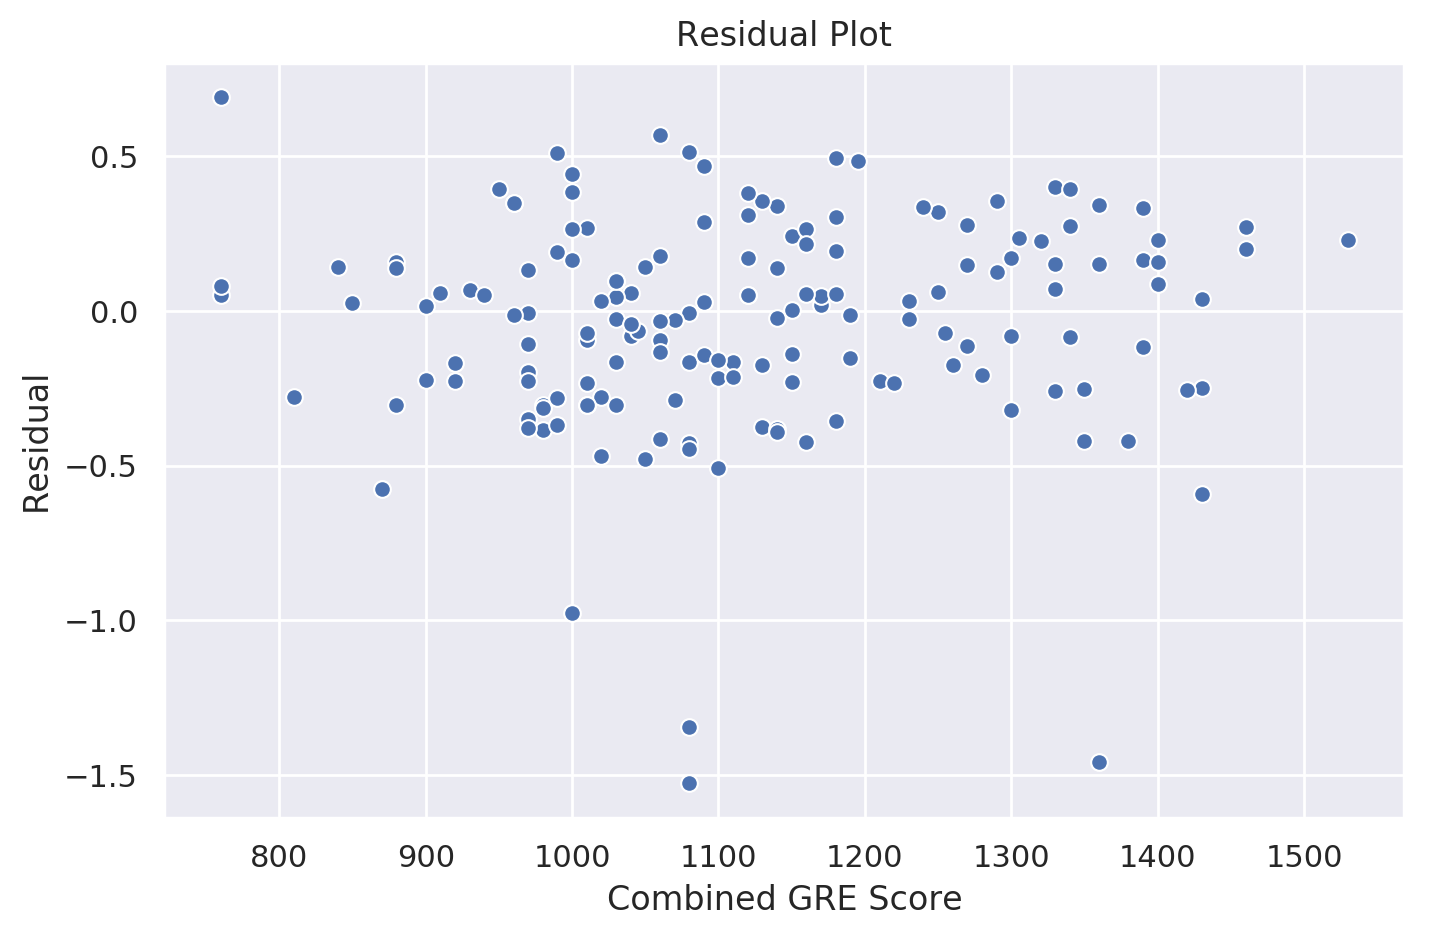

In [13]:
plot_large()
sns.scatterplot(x=np.hstack(X_test), y=residuals)
plt.xlabel('Combined GRE Score')
plt.ylabel('Residual')
plt.title('Residual Plot');

## Problem 2: Dwell Times

In [11]:
reader = spark.read
reader.option("header", True)
reader.option("inferSchema", True)
reader.option("delimiter", "\t")
df = reader.csv(DWELL_TIMES_FILE)

In [12]:
df.show()

+----+----------+
|site|dwell-time|
+----+----------+
|  13|        28|
|   6|        33|
|  17|        81|
|   1|        67|
|  16|        87|
|   2|        56|
|   2|        72|
|   6|       297|
|  13|         2|
|   1|        94|
|   5|       210|
|   4|        49|
|   8|       152|
|   2|        31|
|   5|       146|
|  10|       226|
|   9|       152|
|   1|         7|
|  12|        17|
|  10|       105|
+----+----------+
only showing top 20 rows

